# Setup

In [1]:
import gc
gc.enable()

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(category=FutureWarning, action='ignore')
warnings.filterwarnings(category=UserWarning, action='ignore')
warnings.filterwarnings(category=DeprecationWarning, action='ignore')

import time
import joblib
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.base import clone
from sklearn.model_selection import (
    train_test_split, 
    StratifiedKFold
)
from sklearn.metrics import (
    make_scorer,
    accuracy_score,
    roc_auc_score,
    confusion_matrix
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import (
    LogisticRegression,
    RidgeClassifier
)
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis
)
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import (
    RandomForestClassifier, 
    AdaBoostClassifier,
    HistGradientBoostingClassifier,
    VotingClassifier,
    StackingClassifier
)
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

SEED = 2024

# Data preparation

In [2]:
data = pd.read_csv('/kaggle/input/predict-online-course-engagement-dataset/online_course_engagement_data.csv')

In [3]:
TARGET = 'CourseCompletion'
features = [f for f in data.columns if f not in ('UserID', TARGET)]
cat_features = ['DeviceType', 'CourseCategory']
num_features = [f for f in features if f not in cat_features]

### Preprocessing

In [4]:
def preprocess_dataset(df):
    # remove duplicates
    df = df.drop_duplicates(ignore_index=True)
    
    # one-hot encoding nominal variable
    df = pd.get_dummies(df, columns=['CourseCategory'], dtype='int8')
    
    df['DeviceType'] = df['DeviceType'].astype('int8')
    
    # binarize numerical features
    df['time_spent_above_threshold'] = (df['TimeSpentOnCourse'] > 20).astype('int8')
    df['num_videos_above_threshold'] = (df['NumberOfVideosWatched'] > 5).astype('int8')
    df['num_quizzes_above_threshold'] = (df['NumberOfQuizzesTaken'] > 3).astype('int8')
    df['quiz_scores_above_threshold'] = (df['QuizScores'] > 68).astype('int8')
    df['completion_above_threshold'] = (df['CompletionRate'] > 60).astype('int8')
    
    return df

In [5]:
data = preprocess_dataset(data.copy())

### Feature sets

In [6]:
original_features = [
    'TimeSpentOnCourse', 'NumberOfVideosWatched', 'NumberOfQuizzesTaken', 
    'QuizScores', 'CompletionRate', 'DeviceType', 'CourseCategory_Arts', 
    'CourseCategory_Business', 'CourseCategory_Health', 
    'CourseCategory_Programming', 'CourseCategory_Science'
]

extended_features = [
    'TimeSpentOnCourse', 'NumberOfVideosWatched', 'NumberOfQuizzesTaken', 
    'QuizScores', 'CompletionRate', 'DeviceType', 'CourseCategory_Arts', 
    'CourseCategory_Business', 'CourseCategory_Health', 
    'CourseCategory_Programming', 'CourseCategory_Science', 
    'time_spent_above_threshold', 'num_videos_above_threshold', 
    'num_quizzes_above_threshold', 'quiz_scores_above_threshold', 
    'completion_above_threshold'
]

binary_features = [
    'DeviceType', 'CourseCategory_Arts', 'CourseCategory_Business', 
    'CourseCategory_Health', 'CourseCategory_Programming', 
    'CourseCategory_Science', 'time_spent_above_threshold', 
    'num_videos_above_threshold', 'num_quizzes_above_threshold', 
    'quiz_scores_above_threshold', 'completion_above_threshold'
]

minimal_features = [
    'time_spent_above_threshold', 'num_videos_above_threshold', 
    'num_quizzes_above_threshold', 'quiz_scores_above_threshold', 
    'completion_above_threshold'
]

In [7]:
feature_sets = {
    'Original': original_features,
    'Extended': extended_features,
    'Binary': binary_features,
    'Minimal': minimal_features
}

### Holdout set for model-testing

In [8]:
train, test, _, _ = train_test_split(
    data, data[TARGET],
    stratify=data[TARGET],
    test_size=0.1,  # same size
    shuffle=True,
    random_state=SEED  # same sampling
)

# Base models

In [9]:
preprocessor = StandardScaler()

lda = make_pipeline(
    preprocessor,
    LinearDiscriminantAnalysis(solver='svd', tol=1e-4)
)

qda = make_pipeline(
    preprocessor,
    QuadraticDiscriminantAnalysis(reg_param=0.25, tol=1e-4)
)

gaussiannb = make_pipeline(preprocessor, GaussianNB())

knn = make_pipeline(
    preprocessor,
    KNeighborsClassifier(
        n_neighbors=10, 
        weights='distance', 
        n_jobs=-1
    )
)

mlpnn = make_pipeline(
    preprocessor,
    MLPClassifier(
        activation='relu',
        solver='adam',
        alpha=1e-4,
        learning_rate_init=2e-4,
        max_iter=1000,
        tol=1e-4,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=25,
        random_state=SEED
    )
)

In [10]:
dtree = DecisionTreeClassifier(
    max_depth=6, 
    class_weight='balanced',
    random_state=SEED
)

adaboost = AdaBoostClassifier(
    estimator=dtree, 
    n_estimators=50, 
    learning_rate=0.05,
    algorithm='SAMME',
    random_state=SEED
)

rforest = RandomForestClassifier(
    n_estimators=150, 
    max_depth=6, 
    class_weight='balanced',
    random_state=SEED,
    n_jobs=-1
)

histgradient = HistGradientBoostingClassifier(
    learning_rate=0.02,
    max_iter=1000,
    max_depth=6,
    tol=2e-4,
    early_stopping=True,
    n_iter_no_change=25,
    validation_fraction=0.1,
    scoring=make_scorer(accuracy_score),
    class_weight='balanced',
    random_state=SEED
)

In [11]:
class_ratio = train[TARGET].value_counts()[0] / train[TARGET].value_counts()[1]

XGB_PARAMS = {
    'booster': 'gbtree',
    'tree_method': 'hist',
    'objective': 'binary:logistic',
    'eval_metric': 'error',
    'scale_pos_weight': class_ratio,
    'learning_rate': 0.01,
    'n_estimators': 500,
    'device': 'cpu',
    'enable_categorical': True,
    'max_cat_to_onehot': 2,
    'verbosity': 0,
    'n_jobs': None,
    'seed': SEED
}

xgb = XGBClassifier(**XGB_PARAMS)

In [12]:
CB_PARAMS = {
    'loss_function': 'Logloss',
    'eval_metric': 'Logloss',
    'metric_period': 1,
    'iterations': 500,
    'learning_rate': 0.01,
    'auto_class_weights': 'Balanced',
    'task_type': 'CPU',
    'thread_count': -1,
    'verbose': False,
    'random_state': SEED
}

catb = CatBoostClassifier(**CB_PARAMS)

In [13]:
base_models = [
#     ('lda', lda),
#     ('qda', qda),
    ('gaussiannb', gaussiannb),
    ('knn', knn),
    ('mlpnn', mlpnn),
    ('dtree', dtree),
    ('rforest', rforest),
    ('adaboost', adaboost),
    ('histgradient', histgradient),
    ('xgboost', xgb),
    ('catboost', catb)
]

# Modeling framework

In [14]:
def cross_validate(estimator, feature_set, num_folds=9):
    global train, TARGET
    
    scores_auc, scores_acc = [], []
    X, y = train[feature_set], train[TARGET]
    
    cv = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=SEED)
    for fold, (train_ids, val_ids) in enumerate(cv.split(X, y)):
        X_train, y_train = X.iloc[train_ids], y.iloc[train_ids]
        X_val, y_val = X.iloc[val_ids], y.iloc[val_ids]
        
        model = clone(estimator)
        model.fit(X_train, y_train)
        probs = model.predict_proba(X_val)[:, 1]
        scores_auc.append(roc_auc_score(y_val, probs))
        preds = model.predict(X_val)
        scores_acc.append(accuracy_score(y_val, preds))
        
    scores_df = pd.DataFrame(
        data={'Accuracy': scores_acc, 'ROC-AUC': scores_auc}, 
        index=[f'Fold #{i+1}' for i in range(9)]
    )
    display(scores_df.T)

In [15]:
def refit_full_and_evaluate(model, feature_set):
    global train, test, TARGET
    
    model.fit(train[feature_set], train[TARGET])
    probs = model.predict_proba(test[feature_set])[:, 1]
    preds = model.predict(test[feature_set])
    
    accuracy = accuracy_score(test[TARGET], preds)
    auc = roc_auc_score(test[TARGET], probs)
    print(f'|| Accuracy: {accuracy:.4f} || ROC-AUC: {auc:.4f} ||\n')
    
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.set_title('Normalized Confusion Matrix')
    sns.heatmap(
        data=confusion_matrix(test[TARGET], preds, normalize='true'),
        annot=True, fmt='.4f', linewidths=0.1, cmap=plt.cm.Blues
    )
    plt.xlabel('Prediction')
    plt.ylabel('True label')
    plt.show()
    
    return model

In [16]:
def save_model(model, config, notebook='05'):
    save_path = f'{notebook}_{config}.joblib'
    joblib.dump(model, save_path)

In [17]:
def run_experiment(estimator, model_name, save=True):
    global feature_sets
    
    for fname, fset in feature_sets.items():
        print('\n', '-'*25, fname, '-'*25)
        start_time = time.time()
        print('Cross-validation:')
        cross_validate(estimator, fset)
        print('Refit to full training data and evaluate:\n')
        model = refit_full_and_evaluate(estimator, fset)
        end_time = time.time()
        print(f'\n(Time taken: {end_time - start_time:.2f} secs)')
        
        if save:
            save_model(model, f'{model_name}_{fname}')

# Voting Classifier - Soft
(predicted probabilities)


 ------------------------- Original -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9582,0.9422,0.9557,0.9557,0.9557,0.9495,0.9569,0.9643,0.9704
ROC-AUC,0.9579,0.9372,0.9458,0.9502,0.9537,0.9478,0.9598,0.9615,0.9712


Refit to full training data and evaluate:

|| Accuracy: 0.9631 || ROC-AUC: 0.9636 ||



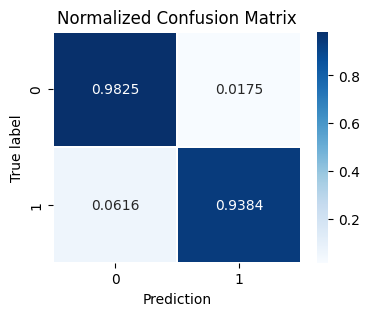


(Time taken: 149.83 secs)

 ------------------------- Extended -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9569,0.9446,0.9581,0.9557,0.9557,0.9495,0.9594,0.9643,0.9729
ROC-AUC,0.9572,0.9390,0.9451,0.9510,0.9525,0.9469,0.9612,0.9617,0.9705


Refit to full training data and evaluate:

|| Accuracy: 0.9643 || ROC-AUC: 0.9643 ||



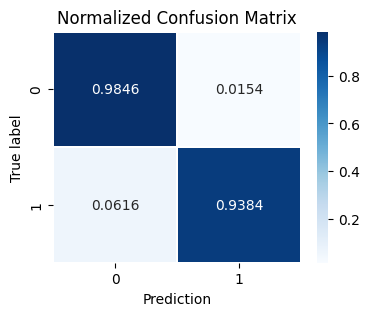


(Time taken: 84.39 secs)

 ------------------------- Binary -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9495,0.9340,0.9437,0.9403,0.9466,0.9382,0.9434,0.9601,0.9653


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9552 ||



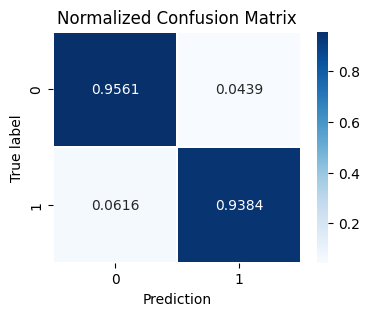


(Time taken: 62.44 secs)

 ------------------------- Minimal -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9503,0.9291,0.9427,0.9405,0.9418,0.9438,0.9457,0.9533,0.9642


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9589 ||



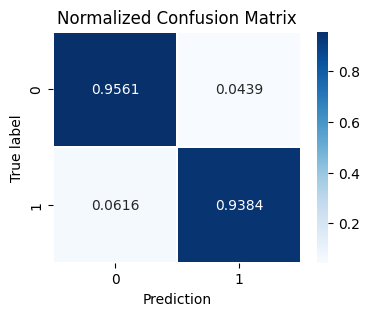


(Time taken: 55.08 secs)


In [18]:
model = VotingClassifier(estimators=base_models, voting='soft')
run_experiment(model, 'softvoting')

# Stacking Classifier - No passthrough 
(only predictions used for stacking)


 ------------------------- Original -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9582,0.9422,0.9557,0.9544,0.9557,0.9483,0.9581,0.9643,0.9717
ROC-AUC,0.9554,0.9487,0.9521,0.9513,0.9600,0.9434,0.9631,0.9628,0.9725


Refit to full training data and evaluate:

|| Accuracy: 0.9631 || ROC-AUC: 0.9648 ||



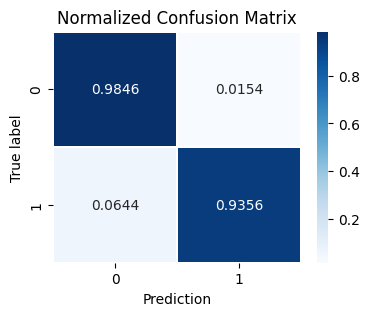


(Time taken: 418.16 secs)

 ------------------------- Extended -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9594,0.9446,0.9581,0.9557,0.9557,0.9495,0.9594,0.9655,0.9729
ROC-AUC,0.9571,0.9473,0.9502,0.9552,0.9601,0.9475,0.9614,0.9584,0.9748


Refit to full training data and evaluate:

|| Accuracy: 0.9643 || ROC-AUC: 0.9644 ||



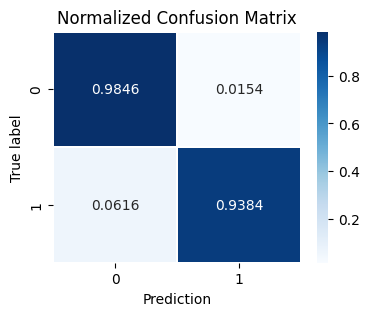


(Time taken: 258.98 secs)

 ------------------------- Binary -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.941,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.948,0.9367,0.9476,0.9469,0.9450,0.9326,0.9485,0.9600,0.9648


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9525 ||



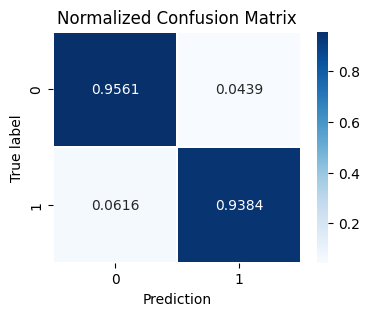


(Time taken: 172.27 secs)

 ------------------------- Minimal -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9522,0.9293,0.9437,0.9413,0.9396,0.9397,0.9478,0.9538,0.9611


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9574 ||



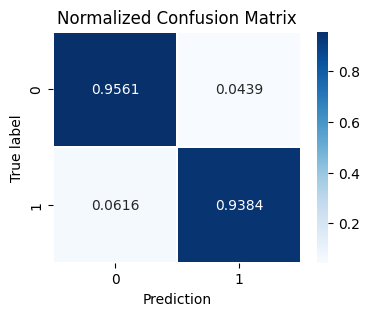


(Time taken: 147.04 secs)


In [19]:
logreg = make_pipeline(
    preprocessor, 
    LogisticRegression(
        solver='saga', max_iter=1000, penalty='elasticnet', l1_ratio=0.5, random_state=SEED)
)

model = StackingClassifier(
    estimators=base_models,
    final_estimator=logreg,
    cv=StratifiedKFold(n_splits=7, shuffle=True, random_state=SEED),
    stack_method='predict_proba',
    passthrough=False,
    n_jobs=-1
)

run_experiment(model, 'stackingnopass')

# Stacking Classifier - Passthrough
(predictions + features used for stacking)


 ------------------------- Original -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9582,0.9422,0.9557,0.9544,0.9557,0.9483,0.9581,0.9643,0.9717
ROC-AUC,0.9584,0.9517,0.9523,0.9558,0.9597,0.9433,0.9618,0.9626,0.9727


Refit to full training data and evaluate:

|| Accuracy: 0.9631 || ROC-AUC: 0.9629 ||



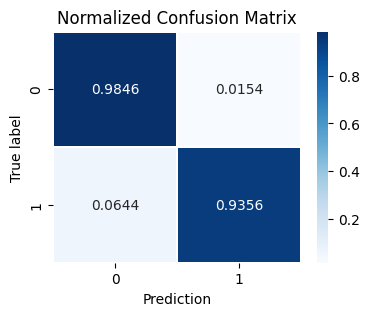


(Time taken: 414.04 secs)

 ------------------------- Extended -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9594,0.9446,0.9581,0.9557,0.9557,0.9495,0.9594,0.9655,0.9729
ROC-AUC,0.9573,0.9511,0.9541,0.9555,0.9578,0.9418,0.9590,0.9578,0.9764


Refit to full training data and evaluate:

|| Accuracy: 0.9643 || ROC-AUC: 0.9632 ||



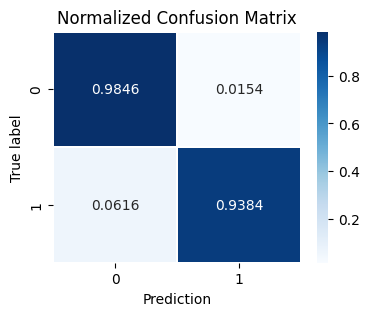


(Time taken: 261.21 secs)

 ------------------------- Binary -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9492,0.9337,0.9454,0.9501,0.9414,0.9307,0.9466,0.9597,0.9661


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9512 ||



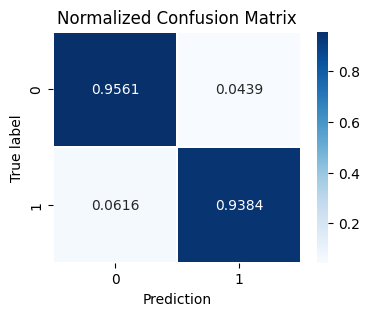


(Time taken: 174.67 secs)

 ------------------------- Minimal -------------------------
Cross-validation:


,Fold #1,Fold #2,Fold #3,Fold #4,Fold #5,Fold #6,Fold #7,Fold #8,Fold #9
Accuracy,0.9410,0.9299,0.9446,0.9409,0.9433,0.9384,0.9372,0.9569,0.9557
ROC-AUC,0.9482,0.9256,0.9431,0.9451,0.9384,0.9351,0.9506,0.9549,0.9630


Refit to full training data and evaluate:

|| Accuracy: 0.9483 || ROC-AUC: 0.9566 ||



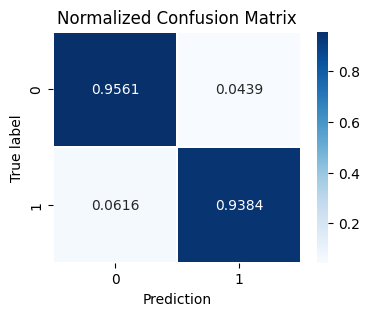


(Time taken: 148.90 secs)


In [20]:
model = StackingClassifier(
    estimators=base_models,
    final_estimator=logreg,
    cv=StratifiedKFold(n_splits=7, shuffle=True, random_state=SEED),
    stack_method='predict_proba',
    passthrough=True,
    n_jobs=-1
)

run_experiment(model, 'stackingpass')